# LangGraph Tutorial: Building a Text Analysis Pipeline

## Introduction to LangGraph

LangGraph is a powerful framework by LangChain designed for creating stateful, multi-actor applications with LLMs. It provides the structure and tools needed to build sophisticated AI agents through a graph-based approach.

Think of LangGraph as an architect's drafting table - it gives us the tools to design how our agent will think and act. Just as an architect draws blueprints showing how different rooms connect and how people will flow through a building, LangGraph lets us design how different capabilities will connect and how information will flow through our agent.

### Key Features:
- **State Management:** Maintain persistent state across interactions
- **Flexible Routing:** Define complex flows between components
- **Persistence:** Save and resume workflows
- **Visualization:** See and understand your agent's structure

In this tutorial, we'll demonstrate LangGraph by building a multi-step text analysis pipeline that processes text through three stages:
1. **Text Classification:** Categorize input text into predefined categories
2. **Entity Extraction:** Identify key entities from the text
3. **Text Summarization:** Generate a concise summary of the input text

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks.

## Setting Up Our Environment

Before diving into the code, let's set up our development environment.

In [ ]:
# Install required packages
!pip install langgraph langchain langchain-openai python-dotenv

### Setting Up API Keys

We'll need an OpenAI API key to use their models. If you haven't already, you can get one from [https://platform.openai.com/signup](https://platform.openai.com/signup).

Let's load our environment variables:

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file (create this with your API key)
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Testing LLM API

Let's make sure our environment is working correctly by creating a simple test with the OpenAI model:

In [4]:
from langchain_openai import ChatOpenAI

# Initialize the ChatOpenAI instance
llm = ChatOpenAI(model="gpt-5-mini")

# Test the setup
response = llm.invoke("Hello! Are you working?")
print(response.content)

Hi — yes, I’m here and ready to help. What would you like to do? You can ask questions, request summaries, get help with writing or code, brainstorm ideas, translate text, troubleshoot problems, and more.


### Building Our Text Analysis Pipeline

Now let's import the necessary packages for our LangGraph text analysis pipeline:

In [5]:
import os
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

### Designing Our Agent's Memory

Just as human intelligence requires memory, our agent needs a way to keep track of information. We create this using a TypedDict to define our state structure:

In [6]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

# Initialize our language model with temperature=0 for more deterministic outputs
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

### Creating Our Agent's Core Capabilities

Now we'll create the actual skills our agent will use. Each of these capabilities is implemented as a function that performs a specific type of analysis.

#### 1. Classification Node

In [8]:
def classification_node(state: State):
    '''Classify the text into one of the categories: News, Blog, Research, or Other'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}

#### 2. Entity Extraction Node

In [7]:
def entity_extraction_node(state: State):
    '''Extract all the entities (Person, Organization, Location) from the text'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}

#### 3. Summarization Node

In [9]:
def summarization_node(state: State):
    '''Summarize the text in one short sentence'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

### Bringing It All Together

Now comes the most exciting part - connecting these capabilities into a coordinated system using LangGraph:

In [10]:
# Create our StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node")  # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

### Visualizing the Workflow

One of the powerful features of LangGraph is the ability to visualize our workflow:

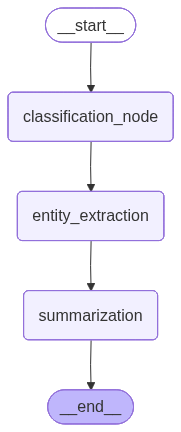

In [11]:
# Display a visualization of our graph
try:
    display(
        Image(
            app.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("The graph structure is: classification_node -> entity_extraction -> summarization -> END")

## Testing Our Agent

Now that we've built our agent, let's see how it performs with a real-world text example:

In [12]:
sample_text = """
We are introducing GPT‑5, our best AI system yet. GPT‑5 is a significant leap in intelligence over all our previous models, featuring state-of-the-art performance across coding, math, writing, health, visual perception, and more. 
It is a unified system that knows when to respond quickly and when to think longer to provide expert-level responses. GPT‑5 is available to all users, with Plus subscribers getting more usage, and Pro subscribers getting access to GPT‑5 pro, a version with extended reasoning for even more comprehensive and accurate answers.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: Blog

Entities: ['GPT‑5', 'GPT‑5 pro', 'Plus', 'Pro']

Summary: GPT‑5 is our most advanced AI yet, delivering superior multi-domain performance with tiered access (Plus for more usage and Pro for extended-reasoning capabilities).


## Understanding the Power of Coordinated Processing

What makes this result particularly impressive isn't just the individual outputs - it's how each step builds on the others to create a complete understanding of the text.

- The **classification** provides context that helps frame our understanding of the text type
- The **entity extraction** identifies important names and concepts
- The **summarization** distills the essence of the document

This mirrors human reading comprehension, where we naturally form an understanding of what kind of text it is, note important names and concepts, and form a mental summary - all while maintaining the relationships between these different aspects of understanding.

## Adding More Capabilities (Advanced)

One of the powerful aspects of LangGraph is how easily we can extend our agent with new capabilities. Let's add a sentiment analysis node to our pipeline:

In [14]:
# First, let's update our State to include sentiment
class EnhancedState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

# Create our sentiment analysis node
def sentiment_node(state: EnhancedState):
    '''Analyze the sentiment of the text: Positive, Negative, or Neutral'''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Analyze the sentiment of the following text. Is it Positive, Negative, or Neutral?\n\nText:{text}\n\nSentiment:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    sentiment = llm.invoke([message]).content.strip()
    return {"sentiment": sentiment}

# Create a new workflow with the enhanced state
enhanced_workflow = StateGraph(EnhancedState)

# Add the existing nodes
enhanced_workflow.add_node("classification_node", classification_node)
enhanced_workflow.add_node("entity_extraction", entity_extraction_node)
enhanced_workflow.add_node("summarization", summarization_node)

# Add our new sentiment node
enhanced_workflow.add_node("sentiment_analysis", sentiment_node)

# Create a more complex workflow with branches
enhanced_workflow.set_entry_point("classification_node")
enhanced_workflow.add_edge("classification_node", "entity_extraction")
enhanced_workflow.add_edge("entity_extraction", "summarization")
enhanced_workflow.add_edge("summarization", "sentiment_analysis")
enhanced_workflow.add_edge("sentiment_analysis", END)

# Compile the enhanced graph
enhanced_app = enhanced_workflow.compile()

### Testing the Enhanced Agent

In [15]:
# Try the enhanced pipeline with the same text
enhanced_result = enhanced_app.invoke({"text": sample_text})

print("Classification:", enhanced_result["classification"])
print("\nEntities:", enhanced_result["entities"])
print("\nSummary:", enhanced_result["summary"])
print("\nSentiment:", enhanced_result["sentiment"])

Classification: Blog

Entities: ['None']

Summary: GPT‑5 is a unified, significantly more intelligent AI with state‑of‑the‑art abilities across many domains, available to all users (Plus grants more usage and Pro provides an extended‑reasoning GPT‑5 Pro).

Sentiment: Positive


### Adding Conditional Edges to the LangGraph Pipeline

### Why **Conditional Edges**?

So far, our graph has followed a fixed linear path:

classification_node → entity_extraction → summarization → (sentiment)

But in real-world applications, we often want to run certain steps only if needed. For example:

- Only extract entities if the text is a News or Research article.

- Skip summarization if the text is very short.

- Add custom processing for Blog posts.

LangGraph makes this easy through conditional edges-logic gates that dynamically route execution based on data in the current state.

### 1. Update the State
We'll use the same EnhancedState from the advanced section:

In [16]:
class EnhancedState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

### 2. Create a Routing Function
This function routes based on classification:

In [17]:
# Route after classification
def route_after_classification(state: EnhancedState) -> str:
    category = state["classification"].lower() # returns: "news", "blog", "research", "other"
    return category in ["news", "research"]

### 3. Define the Graph

In [18]:
from langgraph.graph import StateGraph, END

conditional_workflow = StateGraph(EnhancedState)

# Add nodes
conditional_workflow.add_node("classification_node", classification_node)
conditional_workflow.add_node("entity_extraction", entity_extraction_node)
conditional_workflow.add_node("summarization", summarization_node)
conditional_workflow.add_node("sentiment_analysis", sentiment_node)

# Set entry point
conditional_workflow.set_entry_point("classification_node")

# Add conditional edge
conditional_workflow.add_conditional_edges("classification_node", route_after_classification, path_map={
    True: "entity_extraction",
    False: "summarization"
})

# Add remaining static edges
conditional_workflow.add_edge("entity_extraction", "summarization")
conditional_workflow.add_edge("summarization", "sentiment_analysis")
conditional_workflow.add_edge("sentiment_analysis", END)

# Compile
conditional_app = conditional_workflow.compile()




### 4. Visualize

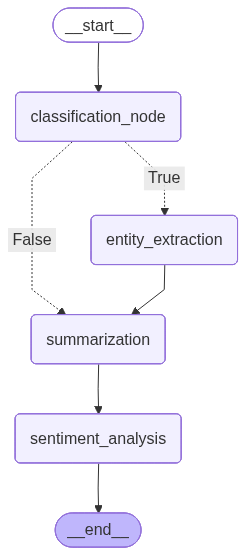

In [20]:
try:
    display(Image(
        conditional_app.get_graph().draw_mermaid_png()
    ))
except:
    print("Graph: classification_node → (conditional) → [entity_extraction or summarization] → sentiment_analysis → END")


### 5. Test the Conditional Pipeline

In [21]:
test_text = """
We are introducing GPT‑5, our best AI system yet. GPT‑5 is a significant leap in intelligence over all our previous models, featuring state-of-the-art performance across coding, math, writing, health, visual perception, and more. 
It is a unified system that knows when to respond quickly and when to think longer to provide expert-level responses. GPT‑5 is available to all users, with Plus subscribers getting more usage, and Pro subscribers getting access to GPT‑5 pro, a version with extended reasoning for even more comprehensive and accurate answers.
"""

result = conditional_app.invoke({"text": test_text})

print("Classification:", result["classification"])
print("Entities:", result.get("entities", "Skipped"))
print("Summary:", result["summary"])
print("Sentiment:", result["sentiment"])


Classification: Blog
Entities: Skipped
Summary: GPT‑5 is our most advanced AI, delivering state‑of‑the‑art performance across multiple domains and available to all users, with more usage for Plus subscribers and an extended‑reasoning Pro version.
Sentiment: Positive


Now, trying with News.

In [22]:
test_text = """
OpenAI released the GPT-4 model with enhanced performance on academic and professional tasks. It's seen as a major breakthrough in alignment and reasoning capabilities.
"""

result = conditional_app.invoke({"text": test_text})

print("Classification:", result["classification"])
print("Entities:", result.get("entities", "Skipped"))
print("Summary:", result["summary"])
print("Sentiment:", result["sentiment"])

Classification: News
Entities: ['OpenAI']
Summary: OpenAI released GPT-4, an improved model excelling at academic and professional tasks and hailed as a major breakthrough in alignment and reasoning.
Sentiment: Positive


With conditional edges, our agent can now:

- Make decisions based on context

- Skip unnecessary steps

- Run faster and cheaper

- Behave more intelligently

## Conclusion

In this notebook, we've:

1. Explored LangGraph concepts and its graph-based approach
2. Built a text processing pipeline with classification, entity extraction, and summarization
3. Enhanced our pipeline with additional capabilities
4. Introduced conditional edges to dynamically control the flow based on classification results
5. Visualized our workflow
6. Tested our agent with real-world text examples

LangGraph provides a powerful framework for creating AI agents by modeling them as graphs of capabilities. This approach makes it easy to design, modify, and extend complex AI systems.